<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Main_1_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive # Google Drive enviroment
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import os

# Change working directory, if needed:
# os.chdir(' ')

# This is for making directories where to save trained model and snapshots:
if os.path.isdir('Trained Models') == False:
    os.mkdir('Trained Models')
if os.path.isdir('snapshots') == False:
    os.mkdir('snapshots')

In [30]:
# Load both training image and MPS 500 MPS realizations
Loaded_data = np.load('/content/drive/MyDrive/Colab Notebooks/Energy AI Jo Proffesor/GAN n DDPM Demo in 2D/MPS_Training_image_and_Realizations_500.npz')
print(Loaded_data.files) # check data

# 2 Array
TI = Loaded_data['array1']
MPS_real = Loaded_data['array2']


['array1', 'array2']


Text(0, 0.5, 'Y axis, 100 ft')

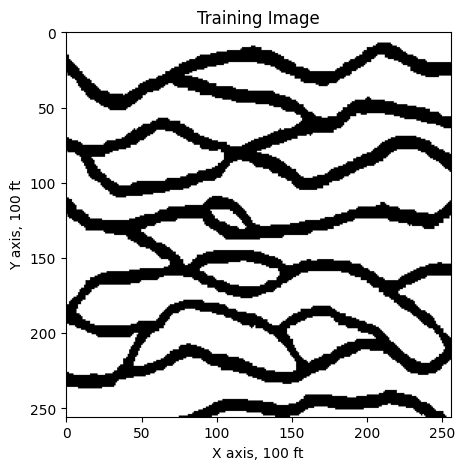

In [31]:
# Visualizae Training image for 2D channel subsurface model:
plt.figure(figsize = (5,5))
plt.imshow(TI, cmap='binary')
plt.title('Training Image')
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

For more details of GSLIB: https://github.com/GeostatsGuy/GeostatsPy

Total Number of realizations: 500 
The dimension of each reservoir model: 128 x 128 in X and Y


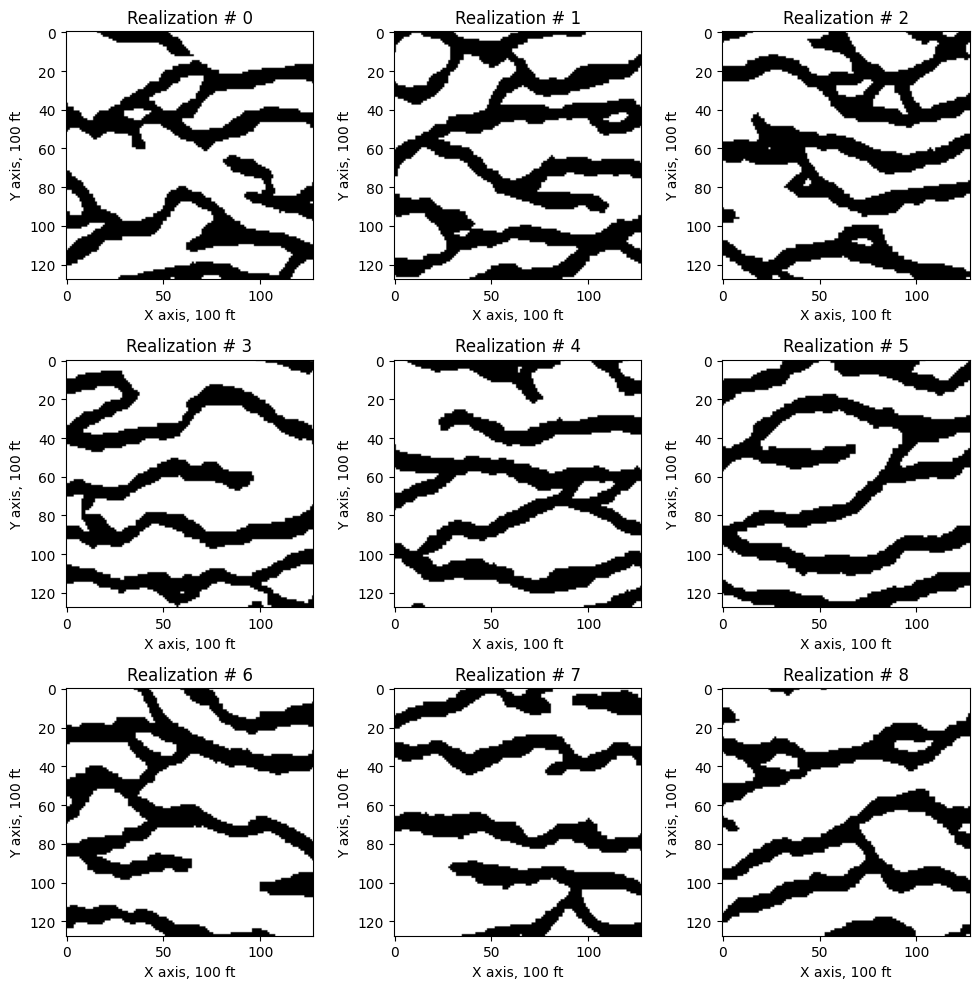

In [32]:
# Visualizae MPS realizations from the above training image:
print('Total Number of realizations: %d \nThe dimension of each reservoir model: %d x %d in X and Y' %(MPS_real.shape[2],MPS_real.shape[0], MPS_real.shape[1]))

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(MPS_real[:,:,i], cmap='binary')
    plt.title('Realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

## Step 1. Define convolutional neural networks for GAN (i.e., Generator and Discriminator)
First we need to define the structure of Generative adversarial network (GAN) to learn the main pattern from the above realizations. Following figure shows the schematic diagram of GAN.

![image.png](attachment:image.png)

Here, both **Generator** and **Discriminator** are convolutional neural networks. **Generator** maps a latent random vector (consists of 100 random variables that follow Gaussian, N(0,1)) to rule-based model whose dimension is 128 x 128 grid cells in x- and y- direction. On the other hands, **discriminator** takes a subsurface model (from either dataset or generator) and compute the probability the input model to be realistic (i.e., having major patterns within training dataset.)

In [33]:
from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import sys
import os # Added import for os module to create directories

class GAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Create output folders if they do not exist
        os.makedirs("snapshots", exist_ok=True)
        os.makedirs("Trained Models", exist_ok=True)

    def build_generator(self):

        model = Sequential()

        # Feature map 1: 100 --> (8x8x64), where (width x height x # of channel)
        model.add(Dense(64 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 64)))

        # Feature map 2: (8x8x64) --> (16x16x32)
        model.add(Conv2DTranspose(32, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        # Feature map 3: (16x16x32) --> (32x32x16)
        model.add(Conv2DTranspose(16, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        # Feature map 4: (32x32x16) --> (64x64x8)
        model.add(Conv2DTranspose(8, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        # Feature map 5: (64x64x8) --> (128x128x4)
        model.add(Conv2DTranspose(4, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        # Feature map 6: (128x128x4) --> (128x128x1)
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("sigmoid"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        # Feature map 1: (128x128x1) --> (64x64x8)
        model.add(Conv2D(8, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        # Feature map 2: (64x64x8) --> (32x32x16)
        model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        # Feature map 3: (32x32x16) --> (16x16x32)
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        # Feature map 4: (16x16x32) --> (8x8x64)
        model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())

        # Feature map 4: (8x8x64) --> 1 (either 1 (for real) or 0 (for fake))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50, save_acc_interval=10):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # To save accuracy of fake and real data
        accuracy_curve = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------         # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise, verbose=0) # Added verbose=0 to suppress predict output

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.save_model(epoch)
            if epoch % save_acc_interval ==0:
                acc = self.save_acc(X_train)
                accuracy_curve.append(acc)
        return accuracy_curve

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise, verbose=0) # Added verbose=0 to suppress predict output

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("snapshots/mnist_%d.png" % epoch) # Changed 'Snapshots' to 'snapshots'
        plt.close()

    def save_model(self, epoch):
        # Changed filename format to include leading zeros for consistency
        self.generator.save(f'Trained Models/Generator_Epoch_{epoch:06d}.keras')

    def save_acc(self, X_train):
        X_fake = self.generator.predict(np.random.normal(0,1,(500,100)), verbose=0).reshape(500,128,128,1) # Added verbose=0
        _, acc_real = self.discriminator.evaluate(X_train, np.ones((500,1)), verbose = 0)
        _, acc_fake = self.discriminator.evaluate(X_fake, np.zeros((500,1)), verbose = 0)
        return [acc_real, acc_fake]

In [41]:
import os
print(os.listdir('Trained Models'))

['Generator_Epoch_9000.keras', 'Generator_Epoch_600.keras', 'Generator_Epoch_7000.keras', 'Generator_Epoch_6000.keras', 'Generator_Epoch_000000.keras', 'Generator_Epoch_1000.keras', 'Generator_Epoch_8000.keras', 'Generator_Epoch_2000.keras', 'Generator_Epoch_0.keras', 'Generator_Epoch_400.keras', 'Generator_Epoch_10000.keras', 'Generator_Epoch_000500.keras', 'Generator_Epoch_3000.keras', 'Generator_Epoch_200.keras', 'Generator_Epoch_800.keras', 'Generator_Epoch_4000.keras', 'Generator_Epoch_5000.keras', 'Generator_Epoch_001000.keras']


In [34]:
# Instanciate
gan = GAN()

# Load training data
X_train = MPS_real.reshape(128,128,1,500)
X_train = np.moveaxis(X_train,-1,0)

# Training GAN
accuracy_curve = gan.train(X_train = X_train,
                           epochs=1001,
                           batch_size=32,
                           save_interval=500,
                           save_acc_interval=10)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,217 (161.00 KB)

 Trainable params: 40,993 (160.13 KB)

 Non-trainable params: 224 (896.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 16, 16, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 32, 32, 16)     │         8,208 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 64, 64, 8)      │         2,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 128, 128, 4)    │           516 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 1)    │            37 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128, 128, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,553 (1.75 MB)

 Trainable params: 457,433 (1.74 MB)

 Non-trainable params: 120 (480.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


## Step 2. Load the trainined GAN
Now we load the trained generator and compare GAN realizations with MPS models. First we will do visual inspection on both models depending on GAN's training process. After that, we will use multi-dimensional scaling to visualize reservoir models in 2D space and analyze similarity between MPS and GAN realizations.

In [42]:
from keras.models import load_model # this is for loading NN models

![image.png](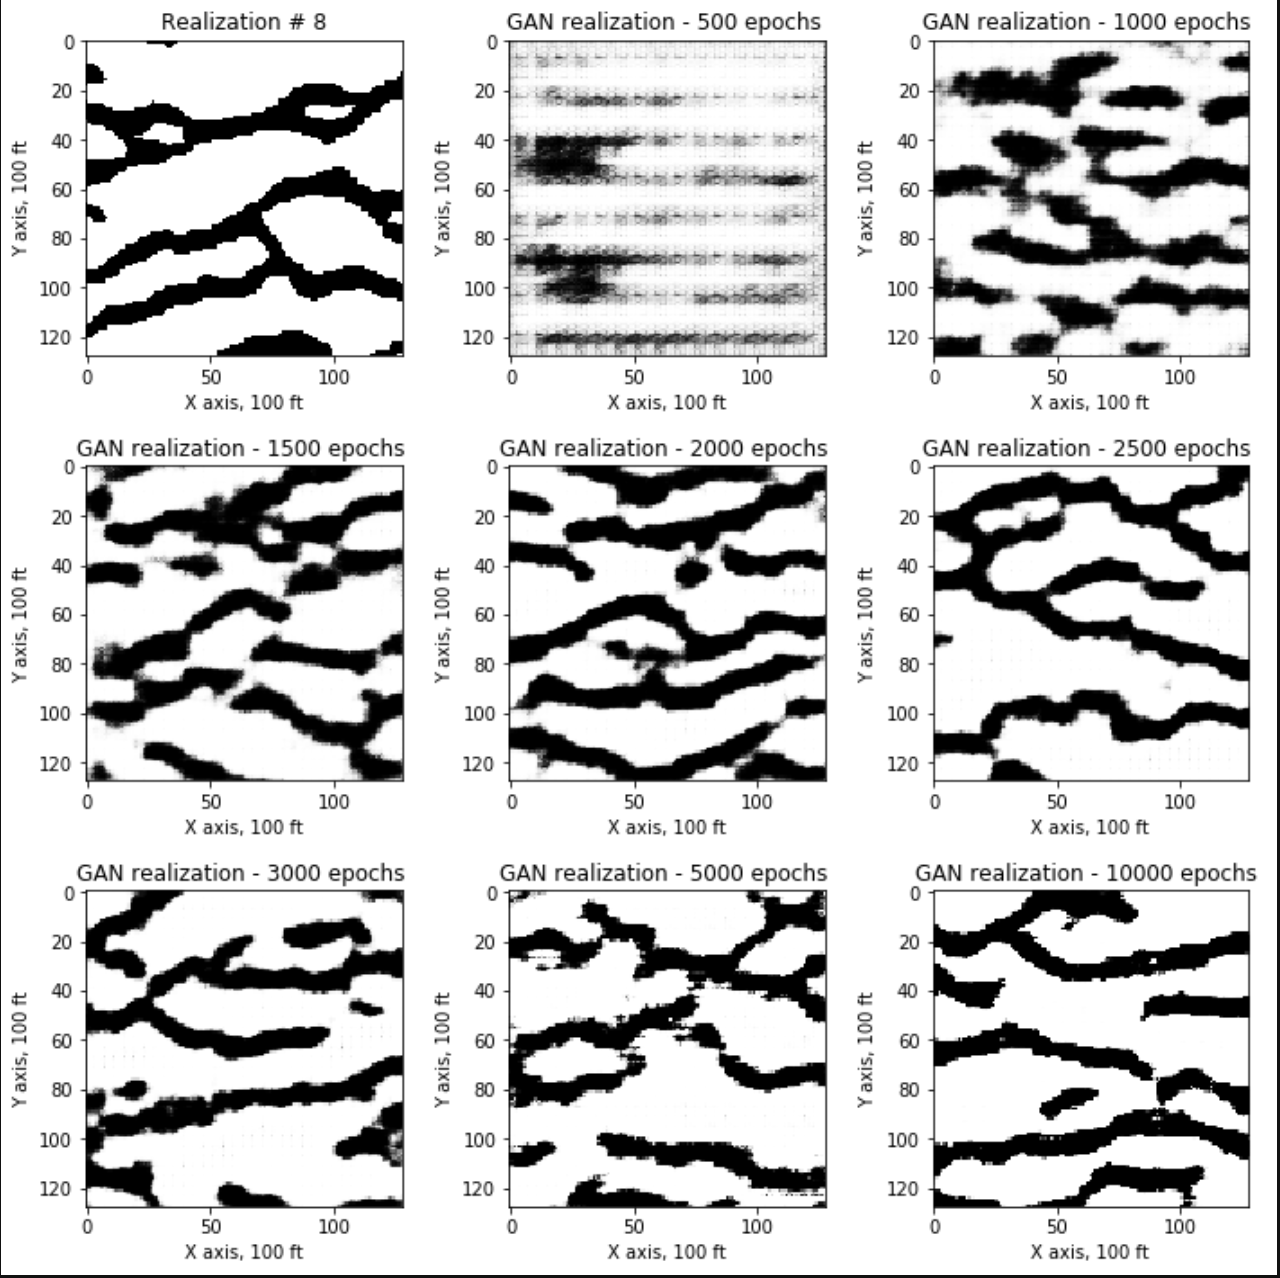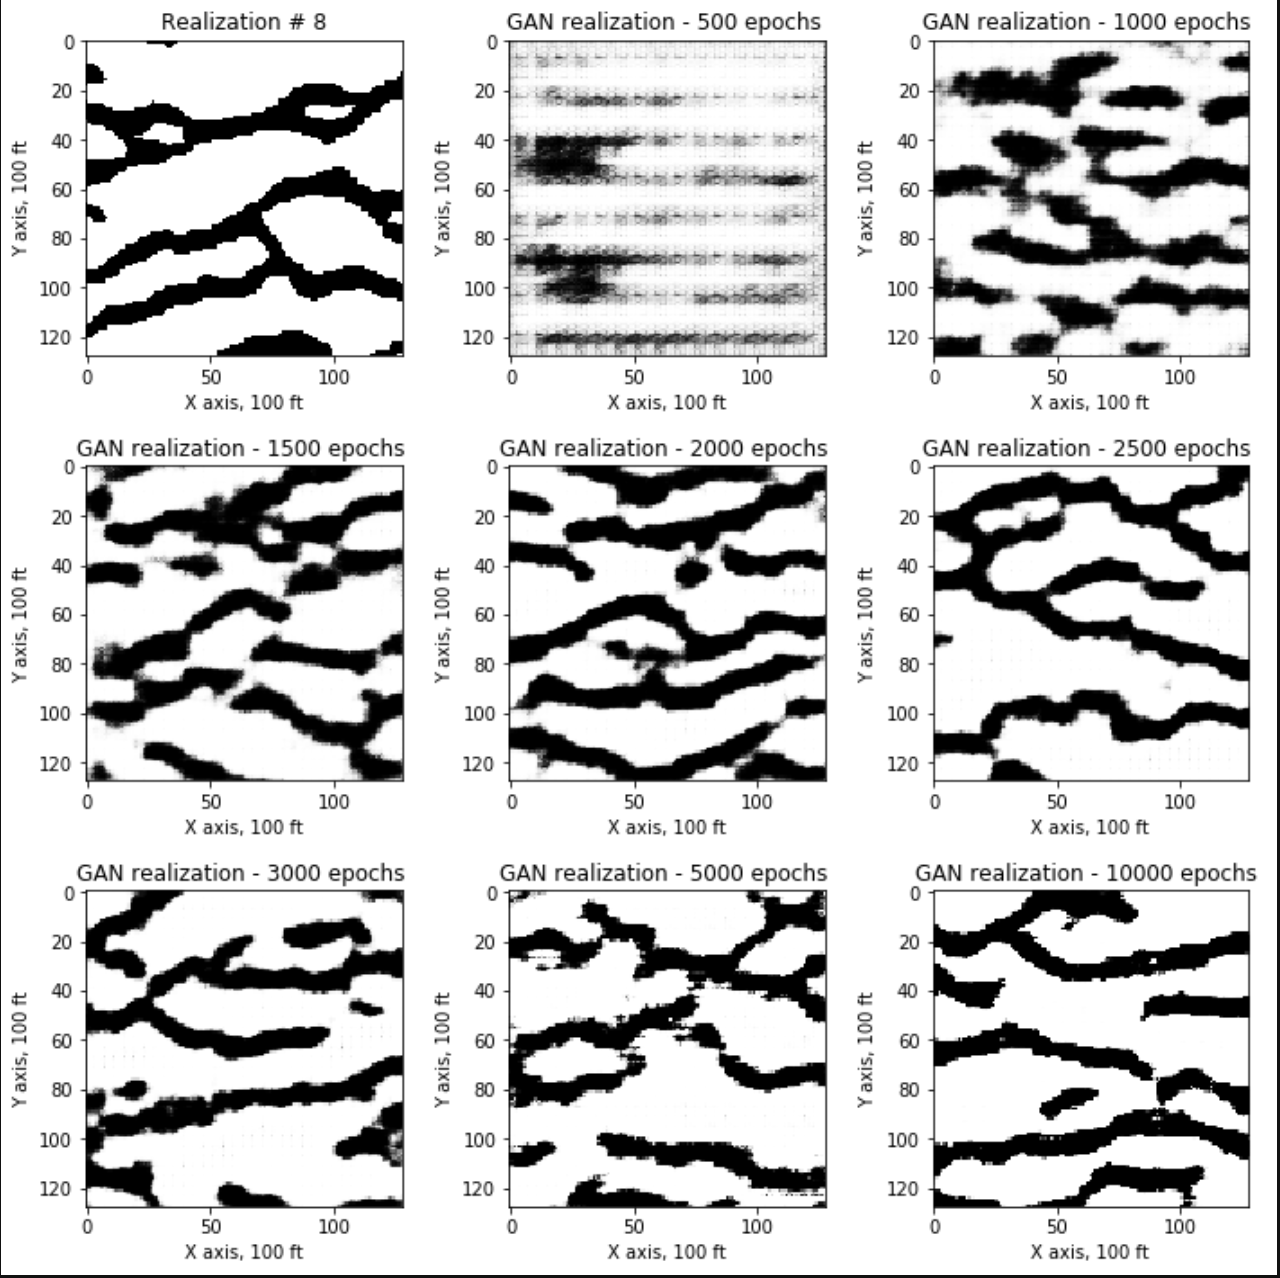)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


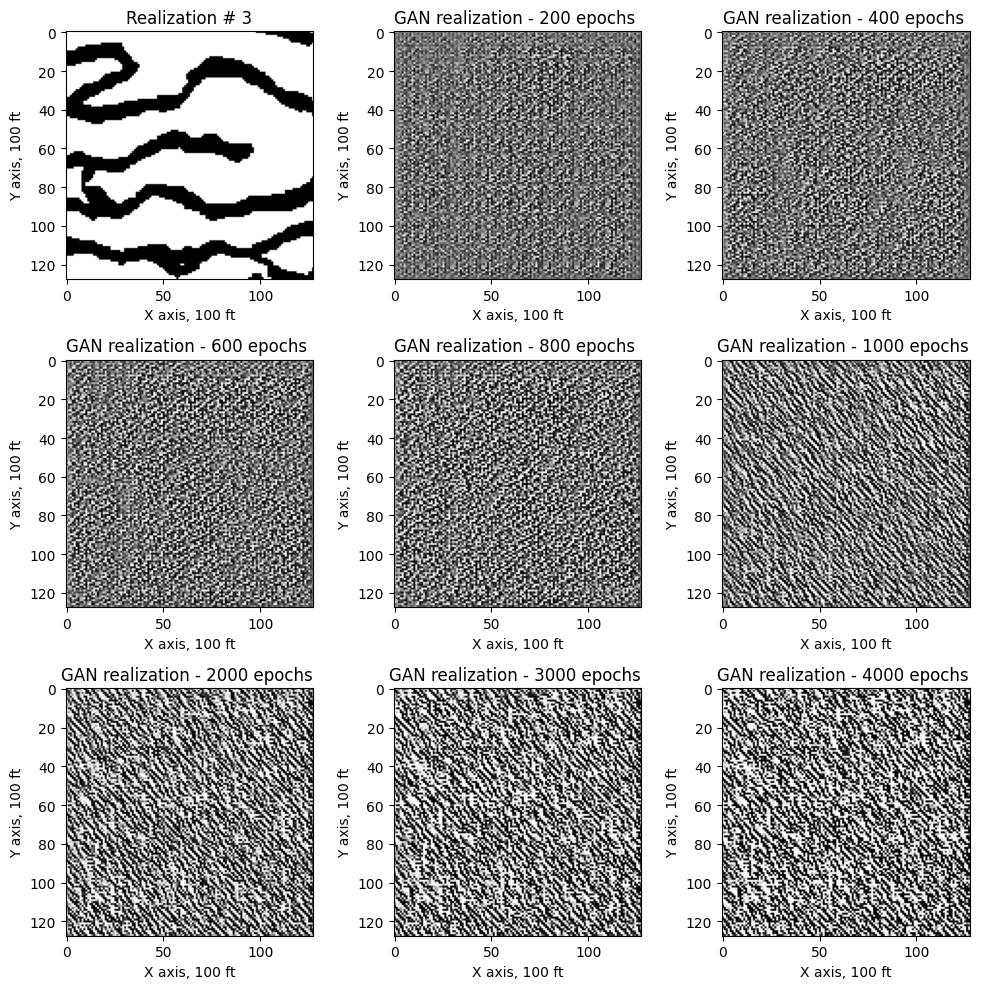

In [44]:
# Visual insepction
plt.figure(figsize = (10,10))
plt.subplot(3,3,1)
plt.imshow(MPS_real[:,:,i], cmap='binary')
plt.title('Realization # %d' %(i))
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

# Updated epochs to match existing non-padded filenames
epochs = [0, 200, 400, 600, 800, 1000, 2000, 3000, 4000] # Adjusting for 9 plots (1 real + 8 GAN)
for i in range(1,9):
    plt.subplot(3,3,i+1)
    # Load without 6-digit padding to match existing files
    Generator = load_model(f'Trained Models/Generator_Epoch_{epochs[i]}.keras')
    GAN_realization = Generator.predict(np.random.normal(0,1,(1,100))).reshape(128,128)
    plt.imshow(GAN_realization, cmap='binary')
    plt.title('GAN realization - %d epochs ' %(epochs[i]))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


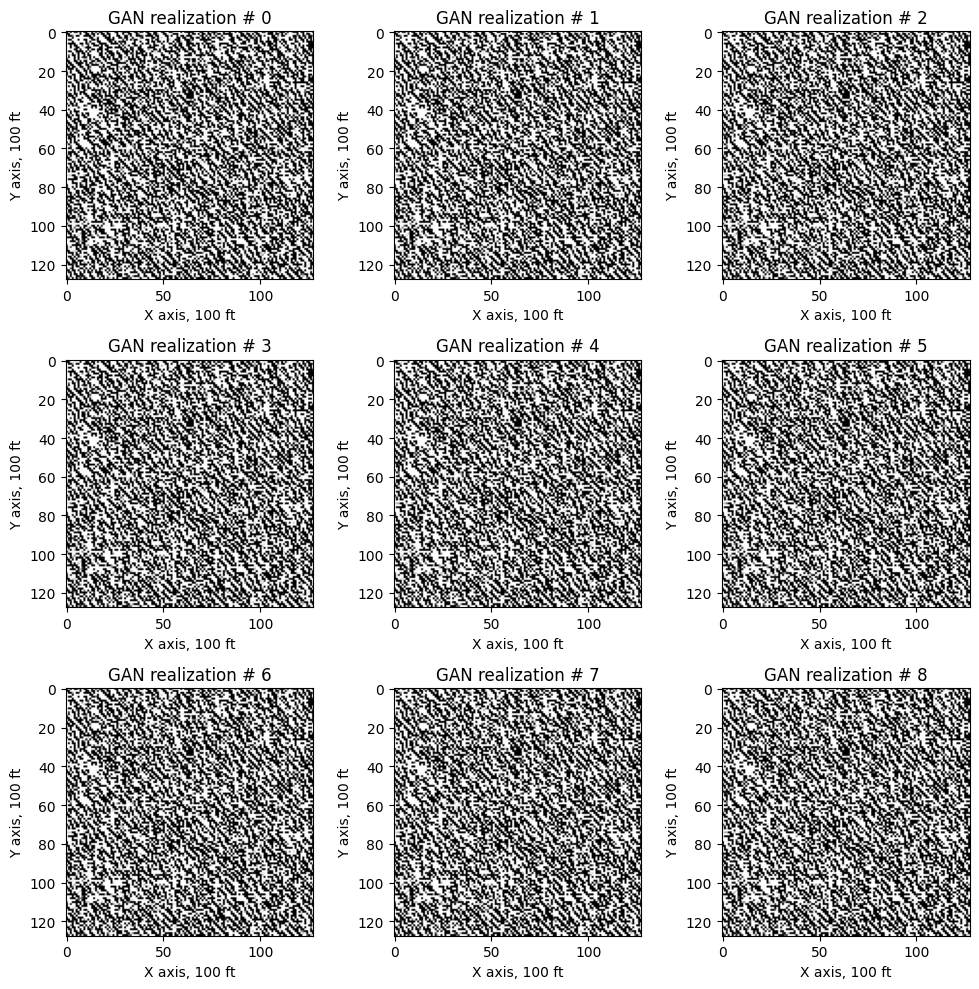

In [48]:
# Load Generator
Generator = load_model('Trained Models/Generator_Epoch_9000.keras')
GAN_realization = Generator.predict(np.random.normal(0,1,(9,100))).reshape(9,128,128)

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(GAN_realization[i, :,:], cmap='binary')
    plt.title('GAN realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


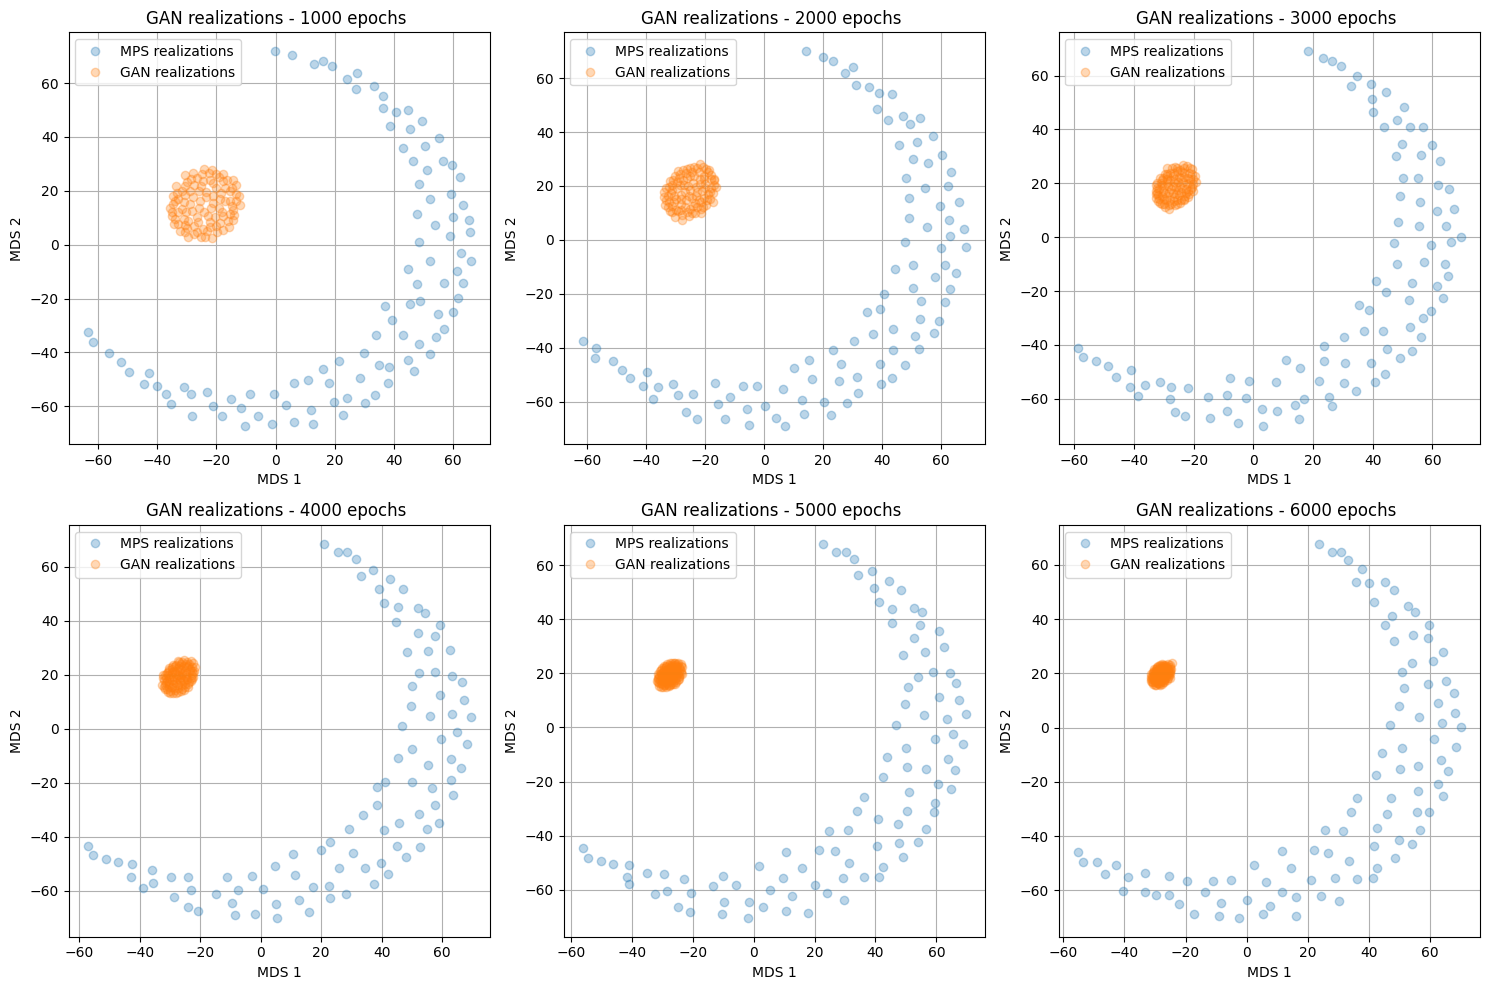

In [54]:
# Visualize similarity in 2D space (MDS)
from sklearn.manifold import MDS
mds = MDS(random_state=123)
MPS_realizations = X_train.reshape(500,-1)[:100]

plt.figure(figsize=(15,10))
# Updated epochs list to match existing non-padded filenames for consistent loading
epochs = [1000, 2000, 3000, 4000, 5000, 6000]
for i in range(6):
    # Map to 2D space
    Generator = load_model('Trained Models/Generator_Epoch_%d.keras' % epochs[i])
    GAN_realizations = Generator.predict(np.random.normal(0,1,(100,100))).reshape(100,-1)
    mds_array = np.concatenate([MPS_realizations, GAN_realizations], axis = 0)
    mds_2D = mds.fit_transform(mds_array)

    plt.subplot(2,3,i+1)
    plt.plot(mds_2D[:100,0],mds_2D[:100,1],'o', alpha = 0.3, label = 'MPS realizations')
    plt.plot(mds_2D[100:,0],mds_2D[100:,1],'o', alpha = 0.3, label = 'GAN realizations')
    plt.title('GAN realizations - %d epochs ' %(epochs[i]))
    plt.grid('on')
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    plt.legend()

plt.tight_layout()